In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options
import adaptive
import tinyarray as ta
from itertools import product
import kwant
from collections import OrderedDict
from scipy.optimize import minimize_scalar
import dask.bag as db

#sys.path.append(os.path.realpath('./../code/'))
import codes.finite_system
import codes.parameters
from codes.tools import linear_Hamiltonian, hamiltonian
from codes.utils import eigsh, voltage_dict
from codes.discretize import discretize_heterostructure
from codes.gate_design import gate_coords

sys.path.append(os.path.realpath('./../spin-qubit/'))
from Hamiltonian import discrete_system_coordinates
from potential import linear_problem_instance

# Adaptive exploration of voltage space

In this notebook we explore the voltage dependence of the Majorana coupling in a trijunction.
The setup is defined in `config`.
It contains details about:
1. Material parameters.
2. Device geometry parameters.
3. Nanowire geometry parameters for `kwant`.


In [3]:
config = {
    "device":
        {"thickness":
            {"dielectric": 3.0, "twoDEG": 2, "gates": 2, "substrate": 5},
        "grid_spacing":
            {"twoDEG": 0.5, "normal": 1, "dielectric": 1, "air": 5, "gate": 0.5, "substrate": 1},
        "permittivity":
            {"metal": 5000, "twoDEG": 15, "air": 1.0, "Al2O3": 9.1, "substrate": 16}},
    "gate":
        {"L": 41.0, "channel_width": 7, "gap": 4.0, "angle": 0.7853981633974483},
    "kwant":
        {"nwl": 150, "nww": 7}
}

## Build system

In [7]:
# build Kwant system
# scattering region is especified from `gate_coords`
gates_vertex, gate_names, boundaries, nw_centers = gate_coords(grid_spacing=1)
geometry, trijunction, f_params = codes.finite_system.kwantsystem(config, boundaries, nw_centers)

In [ ]:
# build poisson problem
poisson_system = discretize_heterostructure(config, boundaries, gates_vertex, gate_names)
linear_problem = linear_problem_instance(poisson_system)

In [ ]:
# extract coordinates of poisson lattice
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [("charge", "twoDEG")], boundaries=None
)

crds = site_coords[:, [0, 1]]
grid_spacing = config["device"]["grid_spacing"]["twoDEG"]
offset = crds[0] % grid_spacing

In [ ]:
# define poisson parameters
poisson_params = {
    "linear_problem": linear_problem,
    "site_coords": site_coords,
    "site_indices": site_indices,
    "offset": offset,
}

In [ ]:
# transform poisson problem to a set of matrices with linear dependence
# on voltages
voltage_regions = list(poisson_system.regions.voltage.tag_points.keys())

base_ham, linear_terms = linear_Hamiltonian(
    poisson_system,
    poisson_params,
    trijunction,
    f_params,
    voltage_regions,
)

In [ ]:
# define base hamiltonian paramters
mu = parameters.bands[0]
params = parameters.junction_parameters([mu, mu, -2])

kwant_params = {'kwant_sys': trijunction,
                'kwant_params_fn': f_params,
                'general_params': params,
                'linear_terms': linear_terms}

In [6]:
# fill trijunction with flat potential
zero_potential = dict(
    zip(ta.array(site_coords[:, [0, 1]]),
        np.zeros(len(site_coords)))
)

kwant_params['general_params'].update(potential=zero_potential)

NameError: name 'site_coords' is not defined

In [27]:
# define initial voltages
pairs = ['right-top', 'left-top', 'left-right']
voltages = OrderedDict()
initial_condition = OrderedDict()
for i, pair in enumerate(pairs):
    initial = [-1.5e-3, -1.5e-3, -1.5e-3, 3e-3]
    initial[i] = -3.5e-3
    voltages[pair] = voltage_dict(initial, True)
    initial_condition[pair] = initial.copy()

In [28]:
import importlib
import plotting
importlib.reload(plotting)

<module 'plotting' from '/home/tinkerer/trijunction-design/code/plotting.py'>

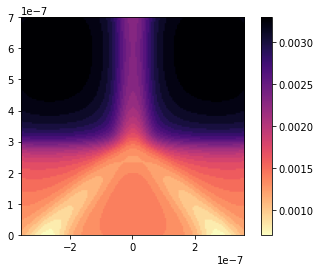

In [30]:
plotting.plot_potential(voltages['left-right'],
                        boundaries,
                        poisson_system,
                        **poisson_params)

## Phase tunning

### Optimisation using `scipy`

In [14]:
# define arguments for optimisation problem
pair = pairs[0]
argv_phase = [pair, voltages[pair]]+list(kwant_params.values())

In [15]:
sol = minimize_scalar(phase_loss,
                      args=tuple(argv_phase),
                      bounds=(0, 2), 
                      method='bounded')

In [18]:
sol

     fun: -5.814551620994629e-05
 message: 'Solution found.'
    nfev: 21
     nit: 21
  status: 0
 success: True
       x: 1.718394501501946

### Uniform grid sampling

In [39]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction_design/"

In [40]:
def solver_hamiltonian_parameters(kwant_system, params_fn, voltages, params):

    params.update(voltages)
    
    def diagonalisation(new_param):
        params.update(new_param)
        numerical_hamiltonian = hamiltonian(
            kwant_system,
            linear_terms,
            voltages,
            params_fn,
            **params)
        return eigsh(numerical_hamiltonian, 20)
    
    return diagonalisation

In [41]:
solver = solver_hamiltonian_parameters(kwant_params['kwant_sys'],
                                       kwant_params['kwant_params_fn'],
                                       voltages['left-right'],
                                       kwant_params['general_params'])

In [42]:
phis = np.linspace(0, 2, 100) * np.pi
args = [{'phi1': phi, 'phi2': 0} for phi in phis]
args_db = db.from_sequence(args)

In [43]:
with Cluster(options) as cluster:
    cluster.scale(10)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(solver).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/cc0acfba62fe4e178edd4b73b8a969cf/status


KilledWorker: ("('from_sequence-a14b462bf6fcd73a4c8d79ec87a56d9f', 26)", <WorkerState 'tls://192.168.3.208:46379', name: ce782e81feec4dbeb70d957889914c66, status: closed, memory: 0, processing: 20>)

In [88]:
solver(args[0])

array([-3.79166818e-04, -3.78219467e-04, -3.44211246e-04, -3.32136570e-04,
       -3.28202028e-04, -3.26375197e-04, -3.25320965e-04, -2.89994728e-04,
       -2.01745494e-07, -1.83075993e-07,  1.83075993e-07,  2.01745494e-07,
        2.89994728e-04,  3.25320965e-04,  3.26375197e-04,  3.28202028e-04,
        3.32136570e-04,  3.44211246e-04,  3.78219467e-04,  3.79166818e-04])

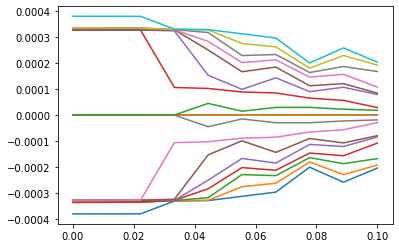

In [57]:
for level in spectras:
    plt.plot(accum_voltages, level)

In [21]:
voltages

OrderedDict([('right-top',
              {'left_1': -0.0035,
               'left_2': -0.0035,
               'right_1': -0.0015,
               'right_2': -0.0015,
               'top_1': -0.0015,
               'top_2': -0.0015,
               'global_accumul': 0.003}),
             ('left-top',
              {'left_1': -0.0015,
               'left_2': -0.0015,
               'right_1': -0.0035,
               'right_2': -0.0035,
               'top_1': -0.0015,
               'top_2': -0.0015,
               'global_accumul': 0.003}),
             ('left-right',
              {'left_1': -0.0015,
               'left_2': -0.0015,
               'right_1': -0.0015,
               'right_2': -0.0015,
               'top_1': -0.0035,
               'top_2': -0.0035,
               'global_accumul': 0.003})])